In [109]:
import cv2
import os
import numpy as np
import shutil
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

### Creating Data

In [110]:
os.chdir(os.path.dirname(os.path.abspath('object_recognition.ipynb')))

In [111]:
## Delete classes from last run of script to set up the new run of the script
shutil.rmtree('./create_classes')
os.makedirs('./create_classes')

In [112]:
## Find all videos
classes = os.listdir('./input_video')
classes = [v.replace('.MOV', '') for v in classes]
classes.remove('.DS_Store')

In [113]:
## Create folders for the pictures which are extracted from every video
## Every video/folder represent one class
for i in classes: os.makedirs('./create_classes/%s' %i)

In [114]:
## Extract pictures from videos and insert them into the prepared folders.
## We end up with one folder per class, filled with pictures from the respective video
for i in classes:
    vidcap = cv2.VideoCapture('input_video/%s.MOV' %i)
    num_frames=int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))-1
    length = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    used_frames=np.unique(np.linspace(1, length, num=num_frames).astype(int))
    success,image = vidcap.read()
    if success: print(i+': Added to data')
    count = 0
    success = True
    while success:
     success,image = vidcap.read()
     if count in used_frames:
       cv2.imwrite('create_classes/'+str(i)+'/frame %s.jpg' %count, image)
     count += 1
     

Item 1: Added to data
Item 2: Added to data
Item 3: Added to data


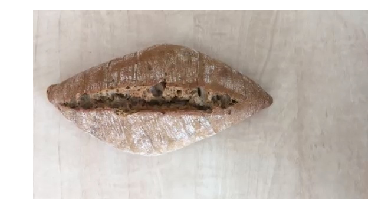

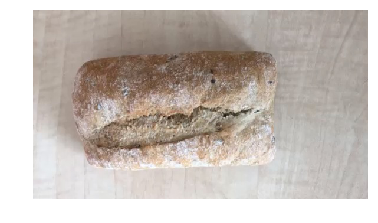

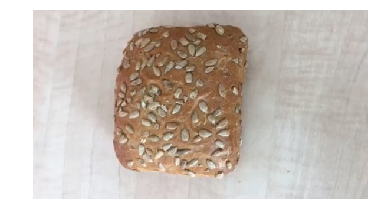

In [115]:
## Plot first image from each class
img=list()
for j in classes:
 img.append(plt.imread('create_classes/%s/frame 1.jpg' %j))

for i in img:
    plt.imshow(i)
    plt.axis("off")
    plt.show()

### Create X_train and y_train

In [116]:
## We now have a folder for every class. The folders are filled with pictures from the respective videos.
## In this step we load the pictures as individual arrays into a list named X_train
## At the same time we create a list which is named y_train. Contains the labels for each picture.
## Label is taken from folder name.
X_train=list()
y_train=list()
for i in classes:
  pic_list=os.listdir('./create_classes/%s' %i)
  for pic in pic_list:
   path='./create_classes/'+i+'/'+pic
   pic=cv2.imread(path,1)
   pic=cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
   X_train.append(pic)
   y_train.append(i)

In [117]:
## Concatenating the lists into numpy arrays 
X_train=np.stack(X_train, axis=0)
y_train=np.stack(y_train, axis=0)

In [118]:
## Encode class values as integers and apply one hot encoding
## This is necessary to feed the data to keras
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)

In [119]:
## Create Models
num_classes = y_train.shape[1]
## num_pixels = X_train.shape[1] * X_train.shape[2]

In [120]:
## Reshape X_train to comply with keras convention
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],3).astype('float32')

In [121]:
## Normalize inputs from 0-255 to 0-1
X_train = X_train / 255

In [122]:
## Split into test and training set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

### Model

In [123]:
import tensorflow as tf

In [124]:
##flatten image to 1D vectore
vector_length=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
pic_num=X_train.shape[0]

In [125]:
X_train=X_train.reshape(pic_num,vector_length)

In [126]:
x = tf.placeholder(tf.float32, [None, X_train.shape[1]])

In [127]:
W = tf.Variable(tf.zeros([vector_length, num_classes]))
b = tf.Variable(tf.zeros([num_classes]))

In [128]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

In [129]:
y_ = tf.placeholder(tf.float32, [None, num_classes])

In [130]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [131]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [132]:
sess = tf.InteractiveSession()

In [133]:
tf.global_variables_initializer().run()

In [134]:
sess.run(train_step, feed_dict={x: X_train, y_: y_train})

In [135]:
##Evaluate
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [136]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [137]:
print(sess.run(accuracy, feed_dict={x: X_train, y_: y_train}))

0.4776
